<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



Importing required libraries for the project



---



In [2]:


# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import math
import matplotlib.pyplot as plt



In [3]:


from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup , Embedding , Flatten



In [4]:


import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()



,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


#Question 1


In [5]:


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature
    


#Question 1 a)

Splitting dataset into train and validation datasets respectively with batch size of 128



---



In [6]:


#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)





---



In this cell we encode categorical features and standardize numerical features




---



In [6]:


# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ] 
)



In [7]:


all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

    



---



In this cell we create a helper function r2_score which will be used to find the r2_score using the predicted as well as true labels



---



In [7]:
from keras import backend as K

def r2_score(y_true, y_pred):
  
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Question 1 b)



---



In this cell, we create a a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation
function), and a linear output layer as well as plot the architecture of the model



---



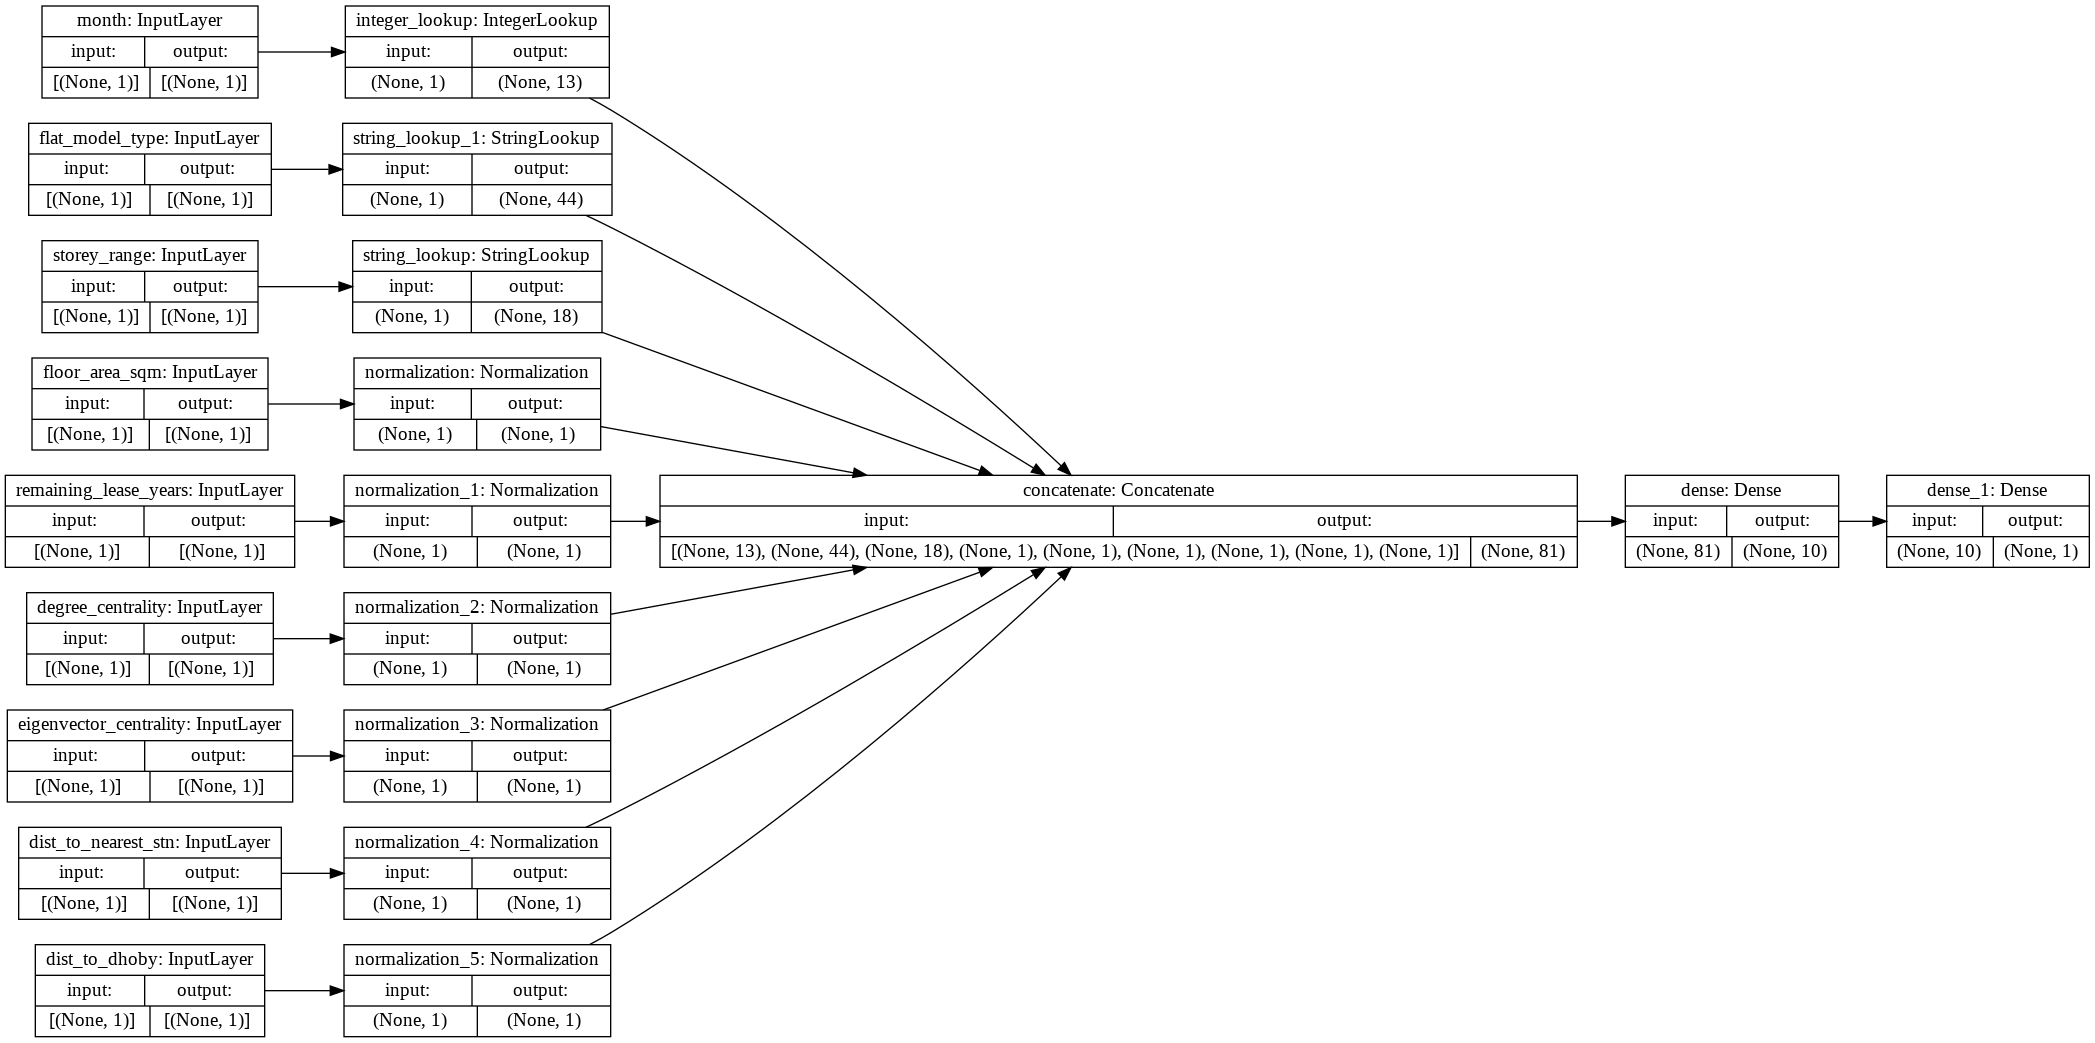

In [9]:


# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")





---



In this cell, a model checkpoint callback was created to save the weights of the model with the minimum val_loss.



---



In [10]:


checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



In [11]:


model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

#Question 1 c)

In [12]:


history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])



Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 187175714816.0000 - r2_score: -7.0488 - val_loss: 170701799424.0000 - val_r2_score: -5.6974
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 67175251968.0000 - r2_score: -1.8795 - val_loss: 39795949568.0000 - val_r2_score: -0.5496
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10803833856.0000 - r2_score: 0.5421 - val_loss: 11000638464.0000 - val_r2_score: 0.5751
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5527165440.0000 - r2_score: 0.7650 - val_loss: 8574937088.0000 - val_r2_score: 0.6689
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4987610112.0000 - r2_score: 0.7872 - val_loss: 7978337792.0000 - val_r2_score: 0.6912
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 4625724416.0000 - r2_score: 0.8025 - val_loss: 7678568960.0000 - val_r2_score: 0.7038
Epoch 7/100
683/683 [=============

#Question 1 d)

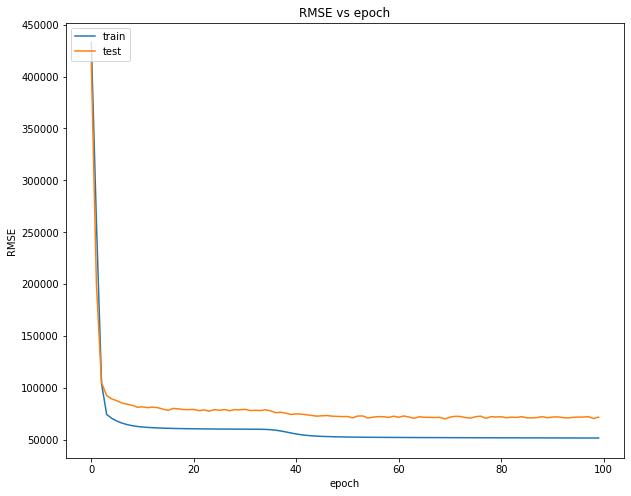

In [14]:


print()
print()
history.history['root_mean_squared_error-question1']=[]
history.history['val_root_mean_squared_error-question1']=[] # this will be used to find the val_root_mean_squared_error from the val_loss by finding the square root of val_loss

for i in range(len(history.history['loss'])):  # Calculating the train RMSE from the train loss
    history.history['root_mean_squared_error-question1'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])): # Calculating the test RMSE from the test loss
    history.history['val_root_mean_squared_error-question1'].append(math.sqrt(history.history['val_loss'][i]))

print()
print()
plt.figure(figsize = (10,8))
plt.plot(history.history['root_mean_squared_error-question1']) # plotting the root_mean_squared_error for training data
plt.plot(history.history['val_root_mean_squared_error-question1']) # plotting the root_mean_squared_error for test data
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
print()



#Question 1 e)



---



In the cell below, we find the loss and r2_score for the epoch with the lowest test error



---



In [18]:


min_rmse = float('inf') #initialising min_
best_r2_score = float('-inf')
epoch_of_min_loss=0

for epoch in range(100):

  if(history.history['val_root_mean_squared_error-question1'][epoch] < min_rmse):
    min_rmse = history.history['val_root_mean_squared_error-question1'][epoch]
    epoch_of_min_loss = epoch
    best_r2_score = history.history['val_r2_score'][epoch]

print('Epoch with the lowest test error - ',(epoch_of_min_loss+1)) #best epoch is epoch_index+1 since index starts from 0
print('best R2 score - ',best_r2_score)



Epoch with the lowest test error -  70
best R2 score -  0.8073295950889587


#Question 1 f)



---



In the cell below, we load the weights of the model with the lowest test error.Then we plot the predicted values and target values for a batch of 128 test samples.



---



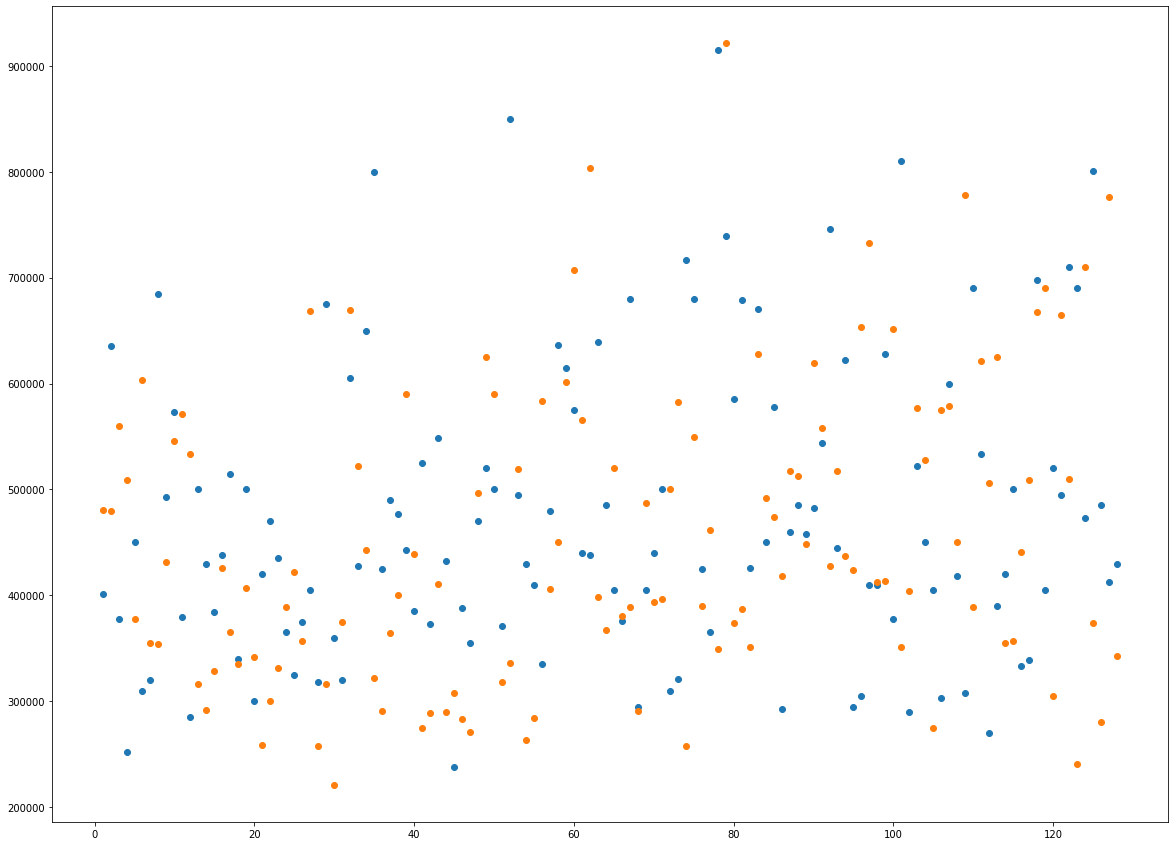

In [44]:


model.load_weights(checkpoint_filepath)
test_predictions = model.predict(val_ds)

'''print()
print()
plt.figure(figsize = (10,8))
test_predictions_batch_128 = test_predictions[:128]
true_values = np.concatenate([y for x, y in val_ds], axis=0)
true_values_batch_128 = true_values[:128]
plt.scatter(true_values_batch_128, test_predictions_batch_128)
print()
print()'''

plt.figure(figsize = (20,15))
true_values = np.concatenate([y for x, y in val_ds], axis=0)
true_values_batch = true_values[:128]
predictions_batch = test_predictions[:128]
true_value_points = []
predicted_value_points = []
sample_number = []
for i in range(128):
  true_value_points.append([i+1,true_values_batch[i]])
  predicted_value_points.append([i+1,predictions_batch[i]])
  sample_number.append(i+1)
plt.scatter(sample_number , true_values_batch)
plt.scatter(sample_number , predictions_batch)
plt.show()



#Question 2



---



In the cell below , we change the output_mode in the encode_categorical_feature to **binary**



---



In [46]:


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

    

In [ ]:


#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)



#Question 2 a)



---



In the cell below,add an Embedding layer with output_dim = floor(num_categories/2) 4 after the one-hot embeddings for categorical variables and then we flatten those embeddings.



---



In [8]:


# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)
month_output_dim = (math.floor(month_encoded.shape[1]/2))
month_encoded_embedding = tf.keras.layers.Embedding(input_dim = month_encoded.shape[1] , output_dim = month_output_dim)(month_encoded)
month_encoded_embedding_flatten = Flatten()(month_encoded_embedding)

# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
storey_range_output_dim = (math.floor(storey_range_encoded.shape[1]/2))
storey_range_encoded_embedding = tf.keras.layers.Embedding(input_dim = storey_range_encoded.shape[1] , output_dim = storey_range_output_dim)(storey_range_encoded)
storey_range_encoded_embedding_flatten = Flatten()(storey_range_encoded_embedding)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_output_dim = (math.floor(flat_model_type_encoded.shape[1]/2))
flat_model_type_encoded_embedding = tf.keras.layers.Embedding(input_dim = flat_model_type_encoded.shape[1] , output_dim = flat_model_type_output_dim)(flat_model_type_encoded)
flat_model_type_encoded_embedding_flatten = Flatten()(flat_model_type_encoded_embedding)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded_embedding_flatten,
        flat_model_type_encoded_embedding_flatten,
        storey_range_encoded_embedding_flatten,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ] 
)



In [10]:


all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]



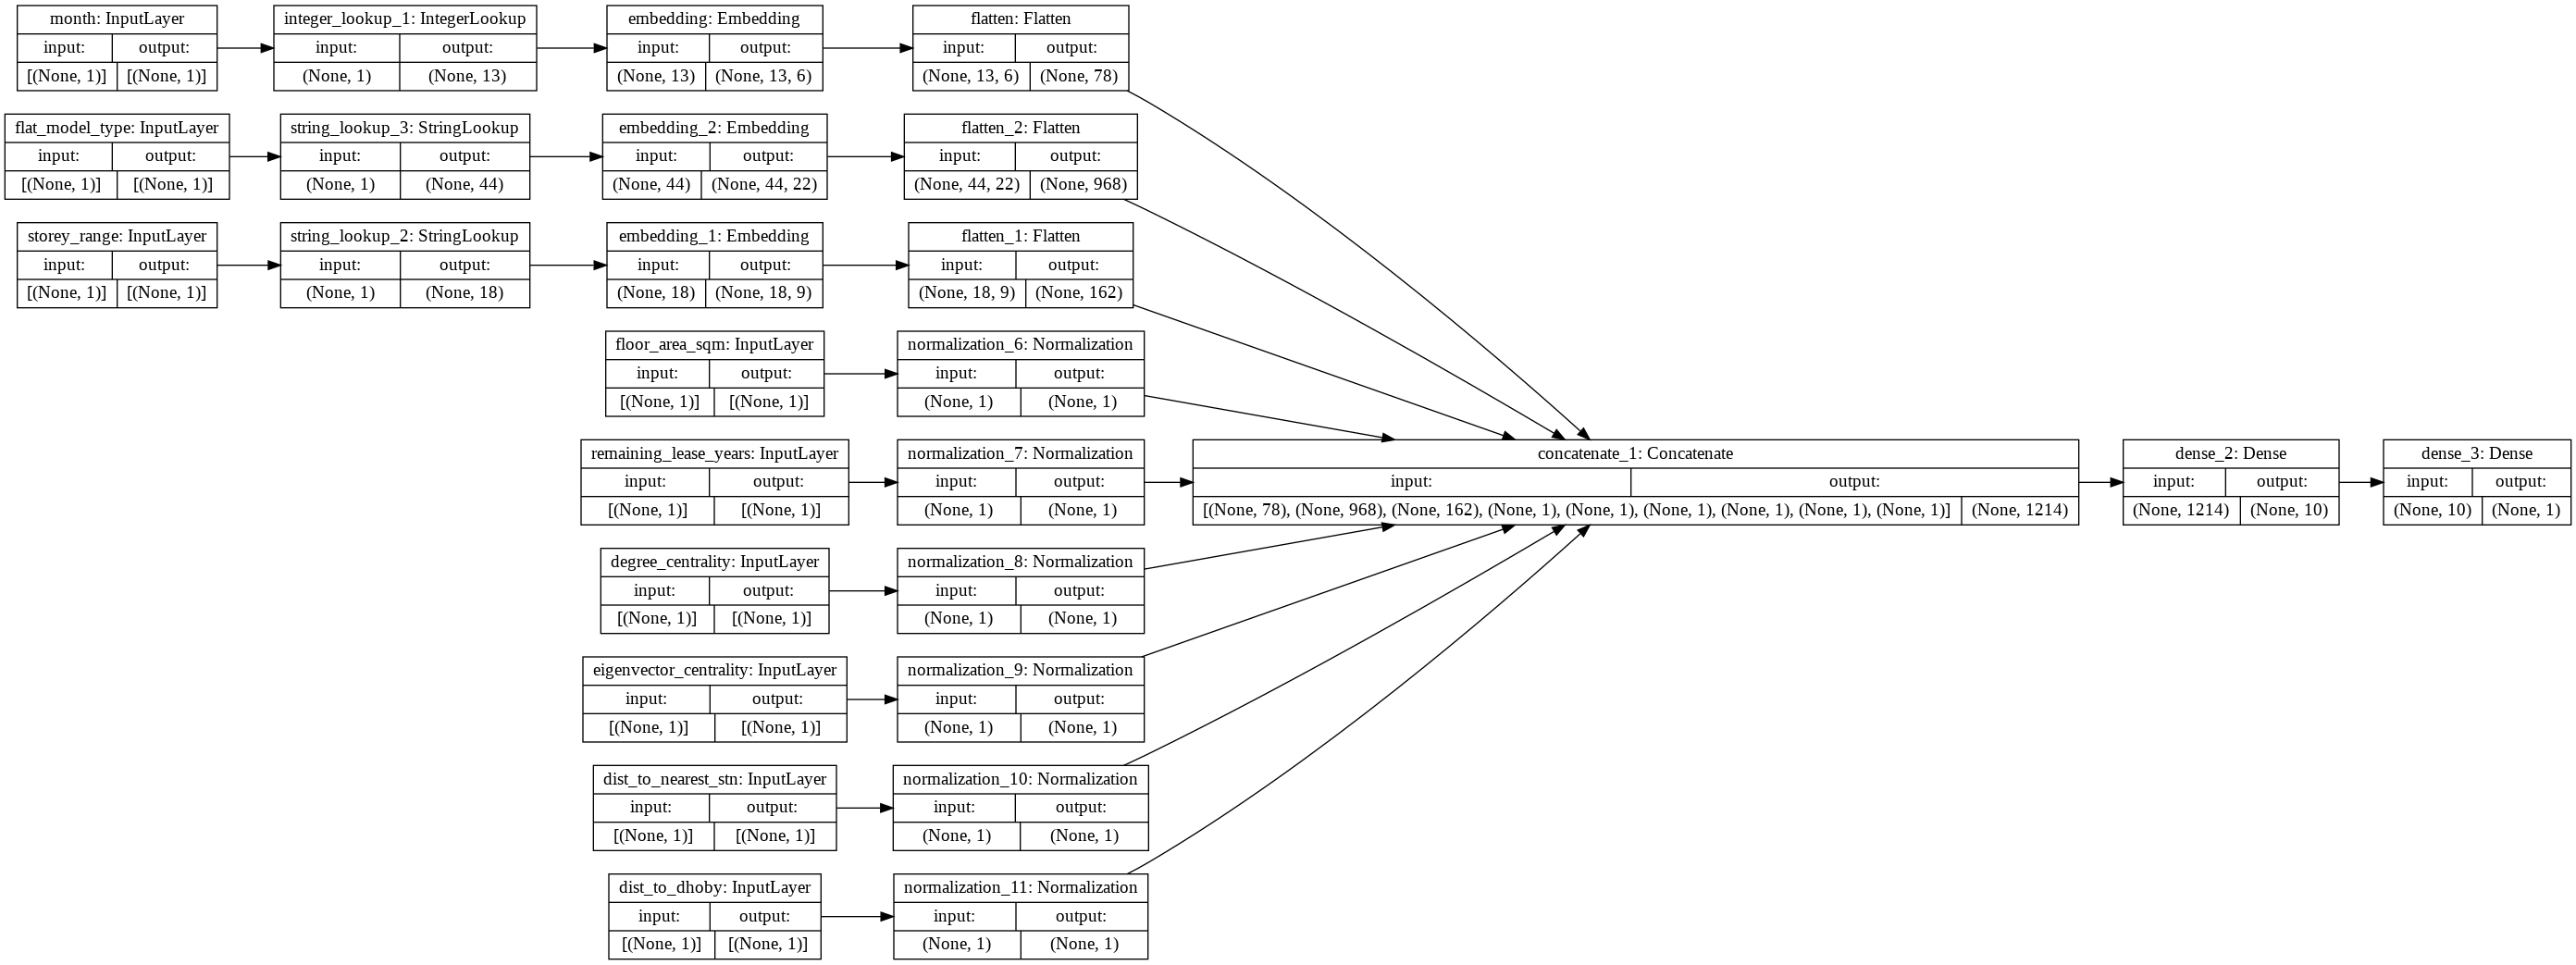

In [49]:


# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")



In [50]:


checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



#Question 2 b)

In [52]:


print()
print()
print('Model with embeddings')
print()
print()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
model.summary()
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])
print()
print()





Model with embeddings


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup_1 (IntegerLookup (None, 13)           0           month[0][0]                      
__________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 6s 7ms/step - loss: 8598690816.0000 - r2_score: 0.6328 - val_loss: 10441155584.0000 - val_r2_score: 0.5958
Epoch 2/100
683/683 [==============================] - 5s 7ms/step - loss: 7290807296.0000 - r2_score: 0.6882 - val_loss: 9981607936.0000 - val_r2_score: 0.6118
Epoch 3/100
683/683 [==============================] - 5s 6ms/step - loss: 6490136576.0000 - r2_score: 0.7222 - val_loss: 7468576768.0000 - val_r2_score: 0.7099
Epoch 4/100
683/683 [==============================] - 5s 7ms/step - loss: 5765354496.0000 - r2_score: 0.7533 - val_loss: 7131402240.0000 - val_r2_score: 0.7243
Epoch 5/100
683/683 [==============================] - 5s 7ms/step - loss: 5269203456.0000 - r2_score: 0.7741 - val_loss: 7608923136.0000 - val_r2_score: 0.7041
Epoch 6/100
683/683 [==============================] - 5s 7ms/step - loss: 4905343488.0000 - r2_score: 0.7888 - val_loss: 7746210304.0000 - val_r2_score: 0.6990
Epoch 7/100
683/683 [========================



---



In the cell below, we plot the root_mean_square_error for the train and test dataset for our new model with embeddings



---



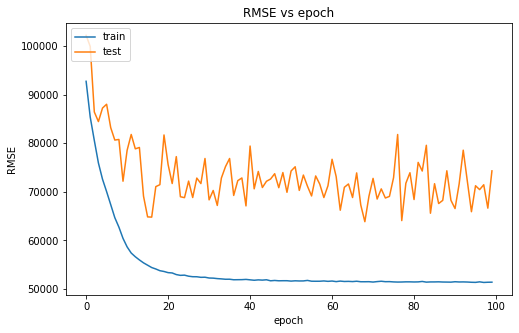

In [56]:


history.history['root_mean_squared_error-question2']=[]
history.history['val_root_mean_squared_error-question2']=[]

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error-question2'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error-question2'].append(math.sqrt(history.history['val_loss'][i]))

plt.figure(figsize = (8,5))
plt.plot(history.history['root_mean_squared_error-question2'])
plt.plot(history.history['val_root_mean_squared_error-question2'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Question 2 c)



---



In this cell, we find the best R2 score as well as minimum root mean squared error for the new model with embeddings



---



In [55]:


min_rmse=float('inf')
best_r2_score=float('-inf')
epoch_of_min_loss=-1
for epoch in range(100):
  if(history.history['val_root_mean_squared_error-question2'][epoch]<min_rmse):
    min_rmse = history.history['val_root_mean_squared_error-question2'][epoch]
    epoch_of_min_rmse = epoch
    best_r2_score = history.history['val_r2_score'][epoch]


print('Minimum test rmse score ', min_loss)
print('best r2 score ',best_r2_score)
print('Epoch of best r2 score ',epoch_of_min_rmse+1)



Minimum test rmse score  63853.630625047466
best r2 score  0.8409258723258972
Epoch of best r2 score  69


#Question 3


In [18]:
from keras.callbacks import EarlyStopping # an early stopping callback with a patience of 10
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10
)

result= {} # a dictionary to save the results of the models after removing features recursively

features_mapping = {  # a mapping to denote the feature name of the corresponding feature tensor
    'month': month_encoded_embedding_flatten,
    'flat_model_type': flat_model_type_encoded_embedding_flatten,
    'storey_range': storey_range_encoded_embedding_flatten,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}


def features_to_tensors_mapping(features): # a helper function that returns the tensorlist for the corresponding feature list
    tensor_list = []
    for feature in features:
        tensor_list.append(features_mapping[feature])
    return tensor_list

def find_best_r2score_root_mean_square_error(history): # a helper function that calculates the best R2 score as well as minimum RMSE from the model history
  best_root_mean_square_error=float('inf')
  best_r2_score=float('-inf')

  for epoch in range(len(history.history['val_r2_score'])):

    if(history.history['val_r2_score'][epoch] >= best_r2_score):
      best_root_mean_square_error = math.sqrt(history.history['val_loss'][epoch])
      best_r2_score = history.history['val_r2_score'][epoch]

  return best_r2_score , best_root_mean_square_error

def build_model(feature_list): # a function that builds and trains the model and returns the history of the trained model

  concatinate_layer = layers.concatenate(feature_list)
  x = layers.Dense(10, activation="relu")(concatinate_layer)
  output = layers.Dense(1, activation="linear")(x)
  model = keras.Model(all_inputs, output)
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
  print()
  print()
  print('Model for Recursive Feature Elimination ')
  print('Features - ',end=' ')
  for element in feature_list:
    print(element,end=' ')
  print()
  print('Total number of features - ',len(feature_list))
  print()
  print()
  history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
  print()
  print()
  return history

def recursive_feature_elimination(features , previous_r2_score, previous_root_mean_square): # a function that recursively eliminates features 

  if(len(features)<=1):
    return

  best_r2_score = float('-inf')
  best_root_mean_square_error = float('inf')
  best_feature_index=-1
  

  for i in range(len(features)):
    tensor_list = features_to_tensors_mapping(features[:i]+features[i+1:])
    history = build_model(tensor_list)
    r2_score , root_mean_square_error = find_best_r2score_root_mean_square_error(history)
    tf.keras.backend.clear_session()

    if(best_r2_score < r2_score):
      best_feature_index = i
      best_r2_score = r2_score
      best_root_mean_square_error = root_mean_square_error
  
  tensor_tuple = features[:best_feature_index]+features[best_feature_index+1:]
  
  if(best_r2_score >= previous_r2_score):
  
    result[tuple(tensor_tuple)] = [best_r2_score , best_root_mean_square_error]
    recursive_feature_elimination(features[:best_feature_index]+features[best_feature_index+1:] , best_r2_score , best_root_mean_square_error)
  
  else:

    result[tuple(tensor_tuple)] = [best_r2_score , best_root_mean_square_error]
    return


feature_list = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

all_features=[
        month_encoded_embedding_flatten,
        flat_model_type_encoded_embedding_flatten,
        storey_range_encoded_embedding_flatten,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]

history = build_model(all_features)
best_r2_score , best_root_mean_square_error = find_best_r2score_root_mean_square_error(history)
result[tuple(feature_list)] = [best_r2_score , best_root_mean_square_error]
tf.keras.backend.clear_session()
recursive_feature_elimination(feature_list , best_r2_score , best_root_mean_square_error)





Model for Recursive Feature Elimination 
Features -  KerasTensor(type_spec=TensorSpec(shape=(None, 78), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'") KerasTensor(type_spec=TensorSpec(shape=(None, 968), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'") KerasTensor(type_spec=TensorSpec(shape=(None, 162), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_2/truediv:0', description="created by layer 'normalization_2'") 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 6ms/step - loss: 28997382144.0000 - r2_score: -0.2293 - val_loss: 13640175616.0000 - val_r2_score: 0.4761
Epoch 2/100
683/683 [==============================] - 4s 6ms/step - loss: 9513784320.0000 - r2_score: 0.5951 - val_loss: 11900327936.0000 - val_r2_score: 0.5398
Epoch 3/100
683/683 [==============================] - 4s 6ms/step - loss: 8339951104.0000 - r2_score: 0.6436 - val_loss: 11150234624.0000 - val_r2_score: 0.5675
Epoch 4/100
683/683 [==============================] - 4s 5ms/step - loss: 7745090560.0000 - r2_score: 0.6683 - val_loss: 10935774208.0000 - val_r2_score: 0.5770
Epoch 5/100
683/683 [==============================] - 4s 5ms/step - loss: 7228942336.0000 - r2_score: 0.6906 - val_loss: 10137088000.0000 - val_r2_score: 0.6069
Epoch 6/100
683/683 [==============================] - 4s 6ms/step - loss: 6679564288.0000 - r2_score: 0.7147 - val_loss: 8744112128.0000 - val_r2_score: 0.6617
Epoch 7/100
683/683 [==================

In [19]:


for key in result.keys():
  print(key,'  ',result[key])

  

('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.8184787631034851, 68158.9708842497]
('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.8397402167320251, 64050.45810921262]
('flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.8243382573127747, 67045.56731059855]


In [20]:


final_table = {}
for key in result.keys():
  temp_list=[]
  for element in feature_list:
    if(element not in key):
      temp_list.append(element)
  final_table[tuple(temp_list)] = [result[key][0],(result[key][1])]



In [25]:


eliminated_features = []
r2_scores_list = []
root_mean_square_error_list = []
for key in result.keys():
  temp=[]
  for element in feature_list:
    if(element not in key):
      temp.append(element)
  eliminated_features.append(temp.copy())
  r2_scores_list.append(result[key][0])
  root_mean_square_error_list.append(result[key][1])



In [26]:


rfe_table = pd.DataFrame(list(zip(eliminated_features , r2_scores_list , root_mean_square_error_list)) , columns=['Eliminated features','R2_Score','Root_Mean_Square_Error'])



In [27]:

%load_ext google.colab.data_table
rfe_table



The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Eliminated features,R2_Score,Root_Mean_Square_Error
0,[],0.818479,68158.970884
1,[degree_centrality],0.839740,64050.458109
2,"[month, degree_centrality]",0.824338,67045.567311
